<a href="https://colab.research.google.com/github/willburr/humorous-headlines/blob/box-plot-gen/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

## Download and install Transformers library

In [1]:
!pip install transformers

     |████████████████████████████████| 1.8MB 19.1MB/s 
     |████████████████████████████████| 3.2MB 43.5MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5ddf1505a7e484dfb95fa55cf28818e717a3ea4a30bc64815eb0317aad83be9c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Project  Set-up

The code blocks below provide the imports and set-up steps to run later sections. We import necessary libraries, set pytorch to use the GPU and load and unzip the data.

In [2]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import torch.optim as optim
import codecs
import tqdm

# Helper code to perform stopword removal
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Imports for use of BERT
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Setting random seed and device
SEED = 1

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Downloading the data

Here we download the data files, load them into pandas and examine the first few columns of the test dataset

In [4]:
!wget -O train.csv https://drive.google.com/u/0/uc?id=1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX&export=download
!wget -O dev.csv https://drive.google.com/u/0/uc?id=19WKir5IRn83NMcVgvNDrmgcDj1UIv7kt&export=download
!wget -O test.csv https://drive.google.com/u/0/uc?id=11pyqg27tGRC1iDo26C2b01bMETqdUwuf&export=download

--2021-02-23 18:44:46--  https://drive.google.com/u/0/uc?id=1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX
Resolving drive.google.com (drive.google.com)... 172.217.5.238, 2607:f8b0:4004:804::200e
Connecting to drive.google.com (drive.google.com)|172.217.5.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lpjckf9kp2arvg3u7ribpjtandj6t8ue/1614105825000/13802342090854404605/*/1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX [following]
--2021-02-23 18:44:47--  https://doc-08-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lpjckf9kp2arvg3u7ribpjtandj6t8ue/1614105825000/13802342090854404605/*/1KS6Cxl4CJnSLkMcdgbnmEdsStlVzacWX
Resolving doc-08-cc-docs.googleusercontent.com (doc-08-cc-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-08-cc-docs.googleusercontent.com (doc-08-cc-docs.googleusercontent.com)|172.217.13.22

In [5]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
# Take a look at the data
test_df.head()

,id,original1,edit1,original2,edit2
0,704-2704,""" Pence Is Trying to Control Republican Politi...",barbers,""" Pence Is Trying to <Control/> Republican Pol...",Bungle
1,704-14395,""" Pence Is Trying to Control Republican Politi...",barbers,""" <Pence/> Is Trying to Control Republican Pol...",Witch
2,2704-14395,""" Pence Is Trying to <Control/> Republican Pol...",Bungle,""" <Pence/> Is Trying to Control Republican Pol...",Witch
3,11098-10186,""" There is no Man Behind the Curtain , "" says ...",elephant,""" There is no Man Behind the Curtain , "" says ...",woman
4,11098-2118,""" There is no Man Behind the Curtain , "" says ...",elephant,""" There is no Man Behind the Curtain , "" says ...",man


## Download and unzip GLOVE Embeddings

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-02-23 18:44:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-23 18:44:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-23 18:44:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [9]:
!unzip '/content/drive/MyDrive/cw/glove.6B.zip'

unzip:  cannot find or open /content/drive/MyDrive/cw/glove.6B.zip, /content/drive/MyDrive/cw/glove.6B.zip.zip or /content/drive/MyDrive/cw/glove.6B.zip.ZIP.


## Training Evaluation Utility Functions

In [41]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, optimizer, scheduler=None):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    for epoch in range(1, number_epoch+1):
        
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            feature, target = batch
            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]

            predictions = model(feature).squeeze(1)
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)

            correct, __ = model_performance(np.argmax(predictions.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            if scheduler:
              scheduler.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct

        valid_loss, valid_acc, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_acc = epoch_loss / no_observations, epoch_correct / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train Accuracy: {epoch_acc:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        val_losses.append(valid_loss)
        val_accs.append(valid_acc)

    return train_losses, train_accs, val_losses, val_accs

In [11]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)
            
            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            correct, __ = model_performance(np.argmax(pred, axis=1), trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_correct += correct
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_correct/no_observations, np.array(pred_all), np.array(trg_all)

In [12]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    correct_answers = (output == target)
    correct = sum(correct_answers)
    acc = np.true_divide(correct,len(output))

    if print_output:
        print(f'| Acc: {acc:.2f} ')

    return correct, acc

In [13]:
def eval_test(data_iter, model, ids, filename):
    """
    Evaluating model performance on the dev set
    """
    model.eval()

    pred_all = []


    with torch.no_grad():
        for batch in data_iter:
            
            batch = batch.to(device)
            # for RNN:
            model.batch_size = batch.shape[1]

            predictions = model(batch).squeeze(1)

            pred = predictions.detach().cpu().numpy()

            pred_all.extend(pred)

    pred_all = np.argmax(np.array(pred_all), axis=1)

    combined = list(zip(ids, pred_all))

    res = pd.DataFrame(combined, columns=['id', 'pred'])
    res.set_index('id', inplace=True, drop=True)

    res.to_csv(filename + '.csv')

    return res

# Data augmentation and Vocab Preparation

The following section provides the functions used to augment the data such that we flip the ordering of input sentences and flip the resulting label. We also define the classes and functions used for creating the vocabulary data structure that maintains mappings between words and indexes.

## Data augmentation

The substitute function performs the injection of the edit word into the original sentence. This is then used in get_edited_df to return the dataframe with columns containing the edited sentences.

In [14]:
import re

def substitute(sentence, edit):
  open_pos = sentence.find('<')
  close_pos = sentence.find('>')
  sub = sentence.replace(sentence[open_pos: close_pos + 1], edit)
  return sub

def get_edited_df(df, test=False):
  id = df['id']
  edited1 = df.apply(lambda x:substitute(x['original1'], x['edit1']), axis=1)
  edited2 = df.apply(lambda x:substitute(x['original2'], x['edit2']), axis=1)
  combined = list(zip(edited1,edited2))
  if test:
    id = df['id']
    combined = list(zip(id,edited1,edited2))
    return pd.DataFrame(combined, columns=['id','edited1', 'edited2'])
  return pd.DataFrame(combined, columns=['edited1', 'edited2'])

edited_train_df = get_edited_df(train_df)
edited_test_df = get_edited_df(test_df, True)

edited_train_df.head()

# We set our training data and test data
training_data = edited_train_df.values.tolist()
labels = list(train_df['label'])
test_data = np.array(edited_test_df.values.tolist())[:,1:].tolist()

## Define Vocab Class

This class stores mappings from word to index and index to words. It also provides utility functions to build the mappings from files or a list data structure.

In [15]:
class Vocabulary(object):
  """Data structure representing the vocabulary of a corpus."""
  def __init__(self):
    # Mapping from tokens to integers
    self._word2idx = {}

    # Reverse-mapping from integers to tokens
    self.idx2word = []

  def word2idx(self, word, default=None):
    """Returns the integer ID of the word or default if not found."""
    return self._word2idx.get(word, default)

  def add_word(self, word):
    """Adds the `word` into the vocabulary."""
    if word not in self._word2idx:
      self.idx2word.append(word)
      self._word2idx[word] = len(self.idx2word) - 1

  def build_from_list(self, words):
    for word in words:
      self.add_word(word)

  def build_from_file(self, fname):
    """Builds a vocabulary from a given corpus file."""
    with open(fname) as f:
      for line in f:
        words = line.strip().split()
        for word in words:
          self.add_word(word)

  def convert_idxs_to_words(self, idxs):
    """Converts a list of indices to words."""
    return ' '.join(self.idx2word[idx] for idx in idxs)

  def convert_words_to_idxs(self, words):
    """Converts a list of words to a list of indices."""
    return [self.word2idx(w) for w in words]

  def __len__(self):
    """Returns the size of the vocabulary."""
    return len(self.idx2word)
  
  def __repr__(self):
    return "Vocabulary with {} items".format(self.__len__())

## Vocab Preparation

create_vocab allows for the tokenization of the corpus and creation of a list of words to be passed to the vocabulary. It provides two flags which the user can set to execute data cleaning operations of punctuation and stopword removal.

In [16]:
def create_vocab(data, remove_punc=True, remove_stopwords=True):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    stop_words = set(stopwords.words('english'))
    
    for sentence_pair in data:
        tokenized_sentence_pair = []
        for sentence in sentence_pair:
            tokenized_sentence = []

            # Split on spaces
            tokens = sentence.split(' ')
            
            # Remove punctuation
            if remove_punc:
              tokens = [word for word in tokens if word.isalnum()]

            # Remove stopwords
            if remove_stopwords:
              tokens = [word for word in tokens if not word in stop_words]

            for token in tokens: 

                tokenized_sentence.append(token.lower())

            tokenized_sentence_pair.append(tokenized_sentence)
        tokenized_corpus.append(tokenized_sentence_pair)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence_pair in tokenized_corpus:

        for sentence in sentence_pair:

            for token in sentence:

                if token.lower() not in vocabulary:

                    vocabulary.append(token.lower())

    return vocabulary, tokenized_corpus

## Load the Dataset

In this section, we present the code that is used to create train and validation pytorch dataloaders with the data augmentation of flipping the input sentences applied to the train dataloader.

### Utility functions

We create a class to hold the dataset to be loaded into the dataloader.

In [17]:
# We create a Dataset so we can create minibatches
class Task2Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

### Creating Dataloaders

The first function, flip_label, is used in the data augmentation process. Then the two following functions are used to create and return pytorch dataloaders for the training and test datasets. note that create_dataloaders splits the dataset into a training and validation set dataloader.

In [34]:
def flip_label(label):
  if label == 1:
    return 2
  elif label == 2:
    return 1
  else: 
    return label

def create_dataloaders(feature, labels, collate_fn, train_proportion=0.8, batch_size=32, flip=True, seed=1):
    torch.manual_seed(seed)

    # 'feature' is a list of lists, each containing embedding IDs for word tokens
    train_and_dev = Task2Dataset(feature, labels)

    train_examples = round(len(train_and_dev)*train_proportion)
    dev_examples = len(train_and_dev) - train_examples

    train_dataset, dev_dataset = random_split(train_and_dev,
                                              (train_examples,
                                                dev_examples))

    if flip:
        # Add the reverse examples to the training set to create more training data
        flipped_train_dataset = []
        for r in train_dataset:
          flipped_train_dataset.append((list(reversed(r[0])), flip_label(r[1])))
        train_dataset += flipped_train_dataset


    # np.random.seed(SEED)
    # np.random.shuffle(train_dataset)
    # idx = torch.randperm(train_dataset.shape[0])
    # train_dataset = train_dataset[idx].view(train_dataset.size()) 
      
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    return train_loader, dev_loader

def create_test_dataloader(feature, collate_fn, batch_size=32):

    test_loader = torch.utils.data.DataLoader(feature, batch_size=batch_size, collate_fn=collate_fn)
    
    return test_loader


# Approach 1: Using pre-trained representations

In this section, we explore three different methods for learning which of the two edited sentences are funnier. We first explore the use of the GloVe embeddings with a BiLSTM, then we use BERT embeddings with the same model structure and finally, we use the entire BERT architecture, including the transformer model.

## 1.1 Using pre-trained (GloVe) embeddings with a BiLSTM model

###Create vocab and load embeddings

In [19]:
# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)

# Creating joint vocab from test and train
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data)

print("Vocab created.")

Vocab created.


In [20]:
# We create representations for our tokens
wvecs = [] # word vectors

vocab = Vocabulary()
# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.300d.txt', 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          vocab.add_word(word)


wvecs = np.array(wvecs)

vectorized_seqs = [[[vocab.word2idx(tok) for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in training_tokenized_corpus]

In [21]:
# Used for collating our observations into minibatches:
def collate_fn_padd(batch, test=False):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    if test:
        batch_features = batch
    else:
        batch_labels = [l for f, l in batch]
        batch_features = [f for f, l in batch]
    
    batch_features_len = [[len(s) for s in b] for b in batch_features]

    seq_tensor = torch.zeros((2, len(batch_features), np.max(batch_features_len))).long()

    # Shape of seq_tensor is batch_size x max_feature_len
    # It should be batch_size x 2 x max_feature_len

    for idx, (seq, seqlens) in enumerate(zip(batch_features, batch_features_len)):
        for i in range(2):
            seq_tensor[i, idx, :seqlens[i]] = torch.LongTensor(seq[i])

    if test:
      return seq_tensor

    batch_labels = torch.LongTensor(batch_labels)
    return seq_tensor, batch_labels

In [35]:
feature = vectorized_seqs

train_loader, dev_loader = create_dataloaders(feature, labels, collate_fn_padd)

print("Dataloaders created.")

Dataloaders created.


### BiLSTM Model definition

In [36]:
class BiLSTM_classification(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, device, num_layers=1, dropout_p=0.2):
        super(BiLSTM_classification, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device=device

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(dropout_p)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout_p)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 4, 3)

    def forward(self, sentence):
        embedding1 = self.emb_dropout(self.embedding(sentence[0]))
        embedding1 = embedding1.permute(1, 0, 2)

        embedding2 = self.emb_dropout(self.embedding(sentence[1]))
        embedding2 = embedding2.permute(1, 0, 2)

        lstm_out_1, _ = self.lstm(embedding1.view(len(embedding1), -1, self.embedding_dim))
        lstm_out_2, _ = self.lstm(embedding2.view(len(embedding2), -1, self.embedding_dim))
        
        # concat both lstm_out_1 and lstm_out_2 and give to our linear layer
        # lstm_out_1[-1] are both batch_size x (2 * hidden_size)
        # We concat so it's batch_size x (2*(2 * hidden_size))
        out = self.hidden2label(torch.cat([lstm_out_1[-1], lstm_out_2[-1]], 1))
        return out

### Model Instantiation and Training

In [42]:
# Number of epochs
epochs = 20

INPUT_DIM = len(vocab) + 1
HIDDEN_DIM = 200 
EMBEDDING_DIM = 300
num_layers = 2
dropout = 0.3

model = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, device, num_layers, dropout)
print("Model initialised.")

model.to(device)

# We provide the model with our embeddings
model.embedding.weight.data[1:].copy_(torch.from_numpy(wvecs))
# Freeze model embeddings
model.embedding.weight.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs, optimizer)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.96 | Train Accuracy: 0.47 |         Val. Loss: 0.95 | Val. Accuracy: 0.50 |
| Epoch: 02 | Train Loss: 0.94 | Train Accuracy: 0.51 |         Val. Loss: 0.95 | Val. Accuracy: 0.50 |


KeyboardInterrupt: ignored

### Obtain test set predictions

In [ ]:
test_vocab, test_tokenized_corpus = create_vocab(test_data)
vectorized_test = [[[vocab.word2idx(tok) for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in test_tokenized_corpus]

test_features = vectorized_test
test_loader = create_test_dataloader(test_features, lambda b: collate_fn_padd(b, test=True))

test_results = eval_test(test_loader, model, edited_test_df['id'], "lstm")

test_results.head()

### Make box plots


In [59]:
# Three Experiments - Punctuation Removal, Stopword Removal and Sentence Flipping
# This cell will take a long time to run, as it trains the model 30 times 

def get_accuracies(train_loader, dev_loader):

  epochs = 20
  INPUT_DIM = len(vocab) + 1
  HIDDEN_DIM = 200 
  EMBEDDING_DIM = 300
  num_layers = 2
  dropout = 0.3
  train_accs = []
  val_accs = []
  max_train_accs = []
  max_val_accs = []

  for i in range(5):

    model = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, device, num_layers, dropout)
    print("Model initialised.")

    model.to(device)

    # We provide the model with our embeddings
    model.embedding.weight.data[1:].copy_(torch.from_numpy(wvecs))
    # Freeze model embeddings
    model.embedding.weight.requires_grad = False

    loss_fn = nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)

    optimizer = torch.optim.Adam(model.parameters())

    _, train_acc, _, val_acc = train(train_loader, dev_loader, model, epochs, optimizer)
    train_accs.append(train_acc[-1])
    val_accs.append(val_acc[-1])
    max_train_accs.append(max(train_acc))
    max_val_accs.append(max(val_acc))

  return train_accs, val_accs, max_train_accs, max_val_accs

# Baseline
print("Running Baseline Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=0, remove_stopwords=0)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=0, remove_stopwords=0)
train_loader, dev_loader = create_dataloaders(feature, labels, collate_fn_padd, flip=0)
baseline_train_accs, baseline_val_accs, max_baseline_train_accs, max_baseline_val_accs = get_accuracies(train_loader, dev_loader)

# Punctuation Removal
print("Running Punctuation Removal Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=1, remove_stopwords=0)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=1, remove_stopwords=0)
train_loader, dev_loader = create_dataloaders(feature, labels, collate_fn_padd, flip=0)
punc_train_accs, punc_val_accs, max_punc_train_accs, max_punc_val_accs = get_accuracies(train_loader, dev_loader)

# Stop Word Removal
print("Running Stop Word Removal Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=0, remove_stopwords=1)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=0, remove_stopwords=1)
train_loader, dev_loader = create_dataloaders(feature, labels, collate_fn_padd, flip=0)
stop_train_accs, stop_val_accs, max_stop_train_accs, max_stop_val_accs = get_accuracies(train_loader, dev_loader)

# Both Data Cleaning
print("Running Both Data Cleaning Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=1, remove_stopwords=1)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=1, remove_stopwords=1)
train_loader, dev_loader = create_dataloaders(feature, labels, collate_fn_padd, flip=0)
clean_train_accs, clean_val_accs, max_clean_train_accs, max_clean_val_accs = get_accuracies(train_loader, dev_loader)

# Data Flipping
print("Running Data Flipping Tests")
training_vocab, training_tokenized_corpus = create_vocab(training_data, remove_punc=1, remove_stopwords=1)
joint_vocab, joint_tokenized_corpus = create_vocab(training_data + test_data, remove_punc=1, remove_stopwords=1)
train_loader, dev_loader = create_dataloaders(feature, labels, collate_fn_padd, flip=1)
flip_train_accs, flip_val_accs, max_flip_train_accs, max_flip_val_accs = get_accuracies(train_loader, dev_loader)


Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.96 | Train Accuracy: 0.45 |         Val. Loss: 0.97 | Val. Accuracy: 0.45 |
| Epoch: 02 | Train Loss: 0.94 | Train Accuracy: 0.51 |         Val. Loss: 0.96 | Val. Accuracy: 0.48 |
| Epoch: 03 | Train Loss: 0.91 | Train Accuracy: 0.56 |         Val. Loss: 0.96 | Val. Accuracy: 0.51 |
| Epoch: 04 | Train Loss: 0.82 | Train Accuracy: 0.62 |         Val. Loss: 0.94 | Val. Accuracy: 0.55 |
| Epoch: 05 | Train Loss: 0.71 | Train Accuracy: 0.70 |         Val. Loss: 0.96 | Val. Accuracy: 0.59 |
| Epoch: 06 | Train Loss: 0.60 | Train Accuracy: 0.75 |         Val. Loss: 1.00 | Val. Accuracy: 0.61 |
| Epoch: 07 | Train Loss: 0.50 | Train Accuracy: 0.79 |         Val. Loss: 1.12 | Val. Accuracy: 0.52 |
| Epoch: 08 | Train Loss: 0.42 | Train Accuracy: 0.83 |         Val. Loss: 1.15 | Val. Accuracy: 0.58 |
| Epoch: 09 | Train Loss: 0.36 | Train Accuracy: 0.86 |         Val. Loss: 1.34 | Val. Accuracy: 0.59 |
| Epoch: 10 | Train Loss: 0.3

KeyboardInterrupt: ignored

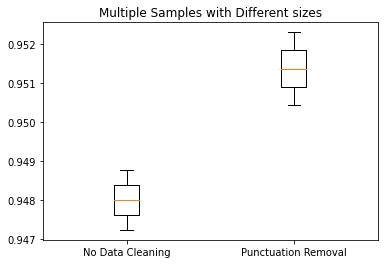

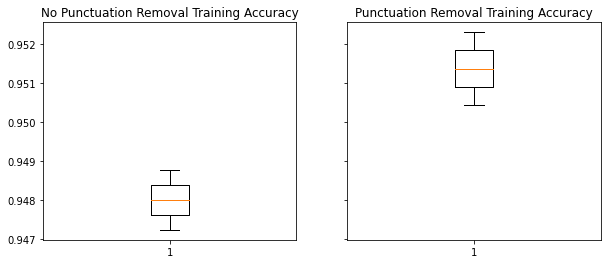

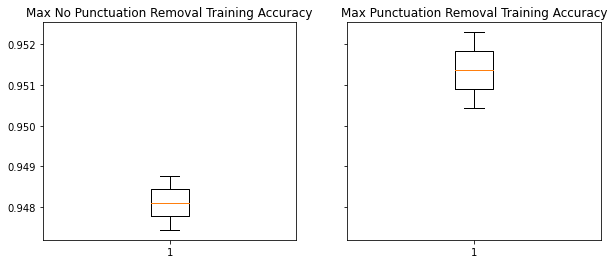

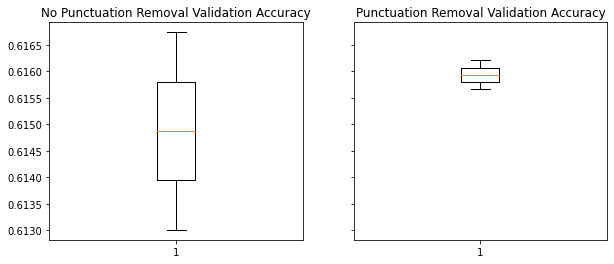

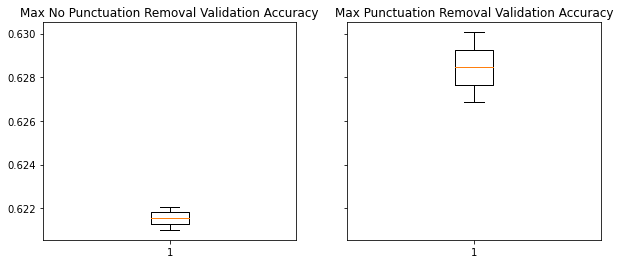

In [63]:
## Plot box plots!
data = {"No Data Cleaning": baseline_train_accs, "Punctuation Removal": punc_train_accs, "Stop Word Removal": stop_train_accs, "Both Data Cleaning": clean_train_accs}
fig1, ax1 = plt.subplots()
ax1.set_title('Traning Accuracy For Data Cleaning')
ax1.boxplot(data.values())
ax1.set_xticklabels(data.keys())
plt.savefig('Data Cleaning Training.pdf', format='pdf')
plt.show()

data = {"No Data Cleaning": baseline_valid_accs, "Punctuation Removal": punc_valid_accs, "Stop Word Removal": stop_valid_accs, "Both Data Cleaning": clean_valid_accs}
fig1, ax1 = plt.subplots()
ax1.set_title('Validation Accuracy For Data Cleaning')
ax1.boxplot(data.values())
ax1.set_xticklabels(data.keys())
plt.savefig('Data Cleaning Validation.pdf', format='pdf')
plt.show()

data = {"No Data Augmentation": clean_train_accs, "Data Augmentation": flip_train_accs}
fig1, ax1 = plt.subplots()
ax1.set_title('Training Accuracy For Data Augmentation')
ax1.boxplot(data.values())
ax1.set_xticklabels(data.keys())
plt.savefig('Data Augmentation Training.pdf', format='pdf')
plt.show()

data = {"No Data Augmentation": clean_valid_accs, "Data Augmentation": flip_valid_accs}
fig1, ax1 = plt.subplots()
ax1.set_title('Validation Accuracy For Data Augmentation')
ax1.boxplot(data.values())
ax1.set_xticklabels(data.keys())
plt.savefig('Data Augmentation Validation.pdf', format='pdf')
plt.show()

## 1.2 Using DistilBERT embeddings

In this section, we will tokenize the sentences using DistilBERT's tokenizer and load the embeddings into a BiLSTM model of the same structure used in the previous section.
 

### Tokenize sentences and load into dataloaders 

In [43]:
# Note that the following ones add an attention mask (used to tell BERT to ignore padding)
def collate_fn_padd_BERT_embeddings(batch, test=False):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    if test:
        batch_features = batch
    else: 
        batch_labels = [l for f, l in batch]
        batch_features = [f for f, l in batch]

    batch_features_len = [[len(s) for s in b] for b in batch_features]

    seq_tensor = torch.zeros((2, len(batch), np.max(batch_features_len))).long()
    mask_tensor = torch.zeros((2, len(batch), np.max(batch_features_len))).long()

    # Shape of seq_tensor is batch_size x max_feature_len
    # It should be batch_size x 2 x max_feature_len

    for idx, (seq, seqlens) in enumerate(zip(batch_features, batch_features_len)):
        for i in range(2):
            seq_tensor[i, idx, :seqlens[i]] = torch.LongTensor(seq[i])
            mask_tensor[i, idx, :seqlens[i]] = torch.ones(seqlens[i])

    feature_tensor = torch.stack([seq_tensor, mask_tensor], dim=1)

    if test:
        return feature_tensor

    batch_labels = torch.LongTensor(batch_labels)
    return feature_tensor, batch_labels

In [44]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

input_id_pairs = []

for (sentence1, sentence2) in training_data:
    encoded_sentence1 = tokenizer.encode(sentence1)
    encoded_sentence2 = tokenizer.encode(sentence2)
    
    # Add the encoded sentence to the list.
    input_id_pairs.append([encoded_sentence1, encoded_sentence2])

train_loader, dev_loader = create_dataloaders(input_id_pairs, labels, collate_fn_padd_BERT_embeddings)

### BiLSTM model with DistilBERT embeddings

In [45]:
class BiLSTM_BERT_classification(nn.Module):

    def __init__(self, hidden_dim, num_layers=1):
        super(BiLSTM_BERT_classification, self).__init__()
        self.hidden_dim = hidden_dim
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased',
            output_hidden_states = True, 
        )
        # The word embedding dimension given by concatenating last 4 hidden 
        # layers of BERT
        self.embedding_dim = 3072


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 4, 3)

    def compute_embeddings(self, feature):
        b_input_ids = feature[0].to(device)
        b_input_mask = feature[1].to(device)

        with torch.no_grad():
            # We aren't trying to train BERT here, only use its embeddings
            self.bert.eval()
            outputs = self.bert(
                b_input_ids,
                attention_mask=b_input_mask
            )
            hidden_states = outputs.hidden_states
        
        return torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1)

    def forward(self, sentences):
        embedding1 = self.compute_embeddings(sentences[0])
        embedding1 = embedding1.permute(1, 0, 2)
        embedding2 = self.compute_embeddings(sentences[1])
        embedding2 = embedding2.permute(1, 0, 2)

        lstm_out_1, _ = self.lstm(embedding1.view(len(embedding1), -1, self.embedding_dim))
        lstm_out_2, _ = self.lstm(embedding2.view(len(embedding2), -1, self.embedding_dim))
        # concat both lstm_out_1 and lstm_out_2 and give to our linear layer, think we need
        # output shape of lstm_ out is 2 * hidden_size as we do it in both directions
 
        # lstm_out_1[-1] are both batch_size x (2 * hidden_size)
        # do we concat so it's (2*batch_size) x (2 * hidden_size) or batch_size x (2*(2 * hidden_size))? - I chose the latter
        out = self.hidden2label(torch.cat((lstm_out_1[-1], lstm_out_2[-1]), 1))
        return out

### Model Instantiation and Training

In [46]:
# Number of epochs
epochs = 8

HIDDEN_DIM = 400 # Higher appears to yield better val acc
num_layers = 4

## TODO: Figure out network dimensions
model = BiLSTM_BERT_classification(HIDDEN_DIM, num_layers)
print("Model initialised.")

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs, optimizer)


Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.97 | Train Accuracy: 0.44 |         Val. Loss: 0.96 | Val. Accuracy: 0.45 |
| Epoch: 02 | Train Loss: 0.95 | Train Accuracy: 0.49 |         Val. Loss: 0.94 | Val. Accuracy: 0.53 |
| Epoch: 03 | Train Loss: 0.90 | Train Accuracy: 0.58 |         Val. Loss: 0.91 | Val. Accuracy: 0.56 |
| Epoch: 04 | Train Loss: 0.80 | Train Accuracy: 0.66 |         Val. Loss: 0.93 | Val. Accuracy: 0.61 |
| Epoch: 05 | Train Loss: 0.66 | Train Accuracy: 0.74 |         Val. Loss: 1.01 | Val. Accuracy: 0.61 |
| Epoch: 06 | Train Loss: 0.52 | Train Accuracy: 0.81 |         Val. Loss: 1.27 | Val. Accuracy: 0.62 |
| Epoch: 07 | Train Loss: 0.41 | Train Accuracy: 0.85 |         Val. Loss: 1.37 | Val. Accuracy: 0.63 |
| Epoch: 08 | Train Loss: 0.34 | Train Accuracy: 0.87 |         Val. Loss: 1.58 | Val. Accuracy: 0.62 |


([0.9659782733860054,
  0.9537144392351561,
  0.9010988997269439,
  0.8007862808941048,
  0.6647316114891377,
  0.5209818066000382,
  0.40716729400794877,
  0.3380095958848702],
 [0.442238507661559,
  0.487475016655563,
  0.5754163890739507,
  0.6574950033311125,
  0.7419720186542305,
  0.8070619586942038,
  0.8457028647568288,
  0.8696202531645569],
 [0.9575647219920209,
  0.9393855516336111,
  0.9080437627682554,
  0.926219058697666,
  1.006913043796889,
  1.2663562058894111,
  1.3719583045699195,
  1.5777956636221424],
 [0.45149253731343286,
  0.5282515991471215,
  0.5628997867803838,
  0.6050106609808102,
  0.6124733475479744,
  0.6183368869936035,
  0.6268656716417911,
  0.6242004264392325])

### Obtain test set predictions

In [ ]:
test_id_pairs = []

for (sentence1, sentence2) in test_data:
    encoded_sentence1 = tokenizer.encode(sentence1)
    encoded_sentence2 = tokenizer.encode(sentence2)
    
    # Add the encoded sentence to the list.
    test_id_pairs.append([encoded_sentence1, encoded_sentence2])

test_loader = create_test_dataloader(test_id_pairs, lambda b: collate_fn_padd_BERT_embeddings(b, test=True))

test_results = eval_test(test_loader, model, edited_test_df['id'], "bert")

test_results.head()

## 1.3 Fine-tuning DistilBERT

The following code uses the pre-trained DistilBERT model as well as it's own embeddings in an attempt to solve the task. We fine tune the model, and evaluate it's performance on the test set as we have done with the others.

### Tokenize sentences and load into dataloaders

In [ ]:
def collate_fn_padd_BERT(batch, test=False):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    if test:
        batch_features = [cls + s1 + sep + s2 for (s1, s2) in batch]
    else: 
        batch_features = [cls + s1 + sep + s2 for (s1, s2), l in batch]
        batch_labels = [l for f, l in batch]

    batch_features_len = [len(f) for f in batch_features]

    seq_tensor = torch.zeros((len(batch_features), max(batch_features_len))).long()
    mask_tensor = torch.zeros((len(batch_features), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
        mask_tensor[idx, :seqlen] = torch.ones(seqlen)

    # Put sequence and tensor together
    feature_tensor = torch.stack([seq_tensor, mask_tensor])

    if test:
        return feature_tensor
  
    batch_labels = torch.LongTensor(batch_labels)
    return feature_tensor, batch_labels

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

input_id_pairs = []

cls = tokenizer.encode('[CLS]')
sep = tokenizer.encode('[SEP]')

for (sentence1, sentence2) in training_data:
    encoded_sentence1 = tokenizer.encode(sentence1, add_special_tokens=False)
    encoded_sentence2 = tokenizer.encode(sentence2, add_special_tokens=False)
    
    # Add the encoded sentence to the list.
    input_id_pairs.append([encoded_sentence1, encoded_sentence2])

train_loader, dev_loader = create_dataloaders(input_id_pairs, labels, collate_fn_padd_BERT, flip=False)

### DistilBert for Humour detection

In [ ]:
class HumourBert(nn.Module):
    def __init__(self):
        super(HumourBert, self).__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', 
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False
        )
    
    def forward(self, feature):
        b_input_ids = feature[0].to(device)
        b_input_mask = feature[1].to(device)
        outputs = self.bert(
            b_input_ids,
            attention_mask=b_input_mask
        )
        return outputs.logits


model = HumourBert().to(device)

### Model Instantiation and Training

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 16

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

train(train_loader, dev_loader, model, epochs, optimizer, scheduler)

### Obtain test set predictions

In [ ]:
test_id_pairs = []

for (sentence1, sentence2) in test_data:
    encoded_sentence1 = tokenizer.encode(sentence1, add_special_tokens=False)
    encoded_sentence2 = tokenizer.encode(sentence2, add_special_tokens=False)
    
    # Add the encoded sentence to the list.
    test_id_pairs.append([encoded_sentence1, encoded_sentence2])

test_loader = create_test_dataloader(test_id_pairs, lambda b: collate_fn_BERT(b, test=True))

test_results = eval_test(test_loader, model, edited_test_df['id'], "bert2")

test_results.head()

# Approach 2: No pre-trained representations

## Create word-index mappings

In [ ]:
vocab = Vocabulary()

# 0-padding token
vocab.add_word('<pad>')
# sentence start
vocab.add_word('<s>')
# sentence end
vocab.add_word('</s>')
# Unknown words
vocab.add_word('<unk>')
vocab.build_from_list(joint_vocab)
print(vocab)
print(vocab.convert_words_to_idxs('the dancer is on the moon'.split()))

## Prepare data
TODO: Reduce duplication

In [ ]:
vectorized_seqs = [[[vocab._word2idx[tok] for tok in sen if tok in vocab._word2idx] for sen in seq] for seq in training_tokenized_corpus]

In [ ]:
labels = list(train_df['label'])

train_loader, dev_loader = create_dataloaders(vectorized_seqs, labels, collate_fn_padd)

print("Dataloaders created.")

## Bi-LSTM model

In [ ]:
# Number of epochs
epochs = 16

INPUT_DIM = len(vocab) + 1
HIDDEN_DIM = 400 
EMBEDDING_DIM = 300 
BATCH_SIZE = 32

## TODO: Figure out network dimensions
model = BiLSTM_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")
model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs, optimizer)

## GRU Model

In [ ]:
class GRU_classification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, device, n_layers, drop_prob=0.2):
        super(GRU_classification, self).__init__()
        self.n_hidden = hidden_dim
        self.n_layers = n_layers
        self.device = device
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb_drop = nn.Dropout(drop_prob)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, bidirectional=True)
        self.hidden_to_out = nn.Linear(hidden_dim * 4, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, sentence):
      self.hidden = self.init_hidden(sentence.shape[1])

      embedding1 = self.emb_drop(self.embedding(sentence[0]))
      embedding1 = embedding1.permute(1, 0, 2)
      embedding2 = self.emb_drop(self.embedding(sentence[1]))
      embedding2 = embedding2.permute(1, 0, 2)

      GRU_out_1, _ = self.gru(embedding1, self.hidden)
      GRU_out_2, _ = self.gru(embedding2, self.hidden)

      out = self.hidden_to_out(self.relu(torch.cat([GRU_out_1[-1], GRU_out_2[-1]], 1)))
      return out
    
    def init_hidden(self, batch_size):
        return torch.zeros((4, batch_size, self.n_hidden), requires_grad=True).to(self.device)

In [ ]:
class BiLSTM_Attention_classification(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, device, num_layers=1, dropout_p=0.2, use_attn=True):
        super(BiLSTM_Attention_classification, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device=device

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(dropout_p)

        self.use_attn = use_attn
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout_p)

        if use_attn:
            self.attn = nn.MultiheadAttention(hidden_dim * 2, num_heads=1)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, 3)
        )

    def forward(self, sentence):
        embedding1 = self.emb_dropout(self.embedding(sentence[0]))
        embedding1 = embedding1.permute(1, 0, 2)

        embedding2 = self.emb_dropout(self.embedding(sentence[1]))
        embedding2 = embedding2.permute(1, 0, 2)

        lstm_out_1, _ = self.lstm(embedding1.view(len(embedding1), -1, self.embedding_dim))
        lstm_out_2, _ = self.lstm(embedding2.view(len(embedding2), -1, self.embedding_dim))

        if self.use_attn:
            out_1 = self.attn(lstm_out_1[-1].unsqueeze(0), lstm_out_1, lstm_out_1)[0].squeeze()
            out_2 = self.attn(lstm_out_2[-1].unsqueeze(0), lstm_out_2, lstm_out_2)[0].squeeze()
        else:
            out_1, out_2 = lstm_out_1[-1], lstm_out_2[-1]
        
        # concat both lstm_out_1 and lstm_out_2 and give to our linear layer
        # lstm_out_1[-1] are both batch_size x (2 * hidden_size)
        # We concat so it's batch_size x (2*(2 * hidden_size))
        out = self.hidden2label(torch.cat([out_1, out_2], 1))
        return out

In [ ]:
# Number of epochs
epochs = 16

INPUT_DIM = len(vocab) + 1
HIDDEN_DIM = 400 
EMBEDDING_DIM = 300 
BATCH_SIZE = 32
OUTPUT_DIM = 3
NUM_BI_LAYERS = 1
NUM_LAYERS = 4

## TODO: Figure out network dimensions
model = BiLSTM_Attention_classification(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, device, NUM_LAYERS, NUM_BI_LAYERS, use_attn=False)
print("Model initialised.")
model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs, optimizer)

## Pre-provided code for approach 2:

In [ ]:
train_and_dev = train_df['edit1']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit1'], train_df['label'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
naive_model = MultinomialNB().fit(train_counts, training_y)

# Train predictions
predicted_train = naive_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = naive_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")

sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + 1  # 1 is most common class
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, torch.tensor(dev_y.values), True)